In [3]:
%matplotlib inline
# imports basicos
import numpy as np
import pandas as pd
import pylab as pl
import matplotlib.pyplot as plt
from pandas.io.pytables import HDFStore
from IPython.core.pylabtools import figsize, getfigs

# Scikit
import sklearn
from sklearn import linear_model
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import MinMaxScaler

from sklearn import linear_model
from sklearn import datasets
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn import linear_model, cross_validation, grid_search
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, average_precision_score

from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier

from sklearn.neural_network import BernoulliRBM

from sklearn.lda import LDA
from sklearn.qda import QDA
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

#from sklearn.preprocessing import Imputer
from matplotlib.colors import ListedColormap

# ggplot
#from ggplot import *

# Deixa os graficos com uma cara mais bonita
pd.set_option('display.mpl_style', 'default')
figsize(18, 5)
pd.set_option('display.max_columns',300)
pd.set_option('display.width', 4000)


# FFT

In [4]:
def nextpow2(i):
    """
    Find 2^n that is equal to or greater than.
    """
    n = 2
    while n < i: n = n * 2
    return n


def bitrev(x):
    """
    Return bit-reversed list, whose length is assumed to be 2^n:
    eg. 0111 <--> 1110 for N=2^4.
    """
    N, x = len(x), x[:]
    if N != nextpow2(N): raise ValueError, 'N is not power of 2'
    for i in range(N):
        k, b, a = 0, N >> 1, 1
        while b >= a:
            if b & i: k = k | a
            if a & i: k = k | b
            b, a = b >> 1, a << 1
        if i < k:  # important not to swap back
            x[i], x[k] = x[k], x[i]
    return x


def fft(x, sign=-1):
    """
    FFT using Cooley-Tukey algorithm where N = 2^n.  The choice of
    e^{-j2\pi/N} or e^{j2\pi/N} is made by 'sign=-1' or 'sign=1'
    respectively.  Since I prefer Engineering convention, I chose
    'sign=-1' as the default.

    FFT is performed as follows:
    1. bit-reverse the array.
    2. partition the data into group of m = 2, 4, 8, ..., N data points.
    3. for each group with m data points,
        1. divide into upper half (section A) and lower half (section B),
        each containing m/2 data points.
        2. divide unit circle by m.
        3. apply "butterfly" operation
            |a| = |1  w||a|	or	a, b = a+w*b, a-w*b
            |b|   |1 -w||b|
        where a and b are data points of section A and B starting from
        the top of each section, and w is data points along the unit
        circle starting from z = 1+0j.
    FFT ends after applying "butterfly" operation on the entire data array
    as whole, when m = N.
    """
    from cmath import pi, exp

    N, W = len(x), []
    for i in range(N):  # exp(-j...) is default
        W.append(exp(sign * 2j * pi * i / N))
    x = bitrev(x)
    m = 2
    while m <= N:
        for s in range(0, N, m):
            for i in range(m / 2):
                n = i * N / m
                a, b = s + i, s + i + m / 2
                x[a], x[b] = x[a] + W[n % N] * x[b], x[a] - W[n % N] * x[b]
        m = m * 2
    return x


In [5]:
from itertools import count
import math

def sine_wave(frequency=440.0, framerate=44000, amplitude=0.9):
    if amplitude > 1.0:
        amplitude = 1.0
    if amplitude < 0.0:
        amplitude = 0.0
    frequency = float(frequency)
    return (amplitude * math.sin(2.0 * math.pi * frequency * (float(i) / framerate)) for i in
            count(0))

def sine_wave_array(size, frequency=440.0, framerate=44000, amplitude=0.9):
    wave = sine_wave(frequency=frequency, framerate=framerate, amplitude=amplitude)
    return [wave.next() for _ in xrange(size)]

def wave_array(size, functions):
    norm = len(functions)
    return [sum((f.next() for f in functions))/norm for _ in xrange(size)]

import random
def white_noise(amplitude=0.5):
    return (float(amplitude) * random.uniform(-1, 1) for _ in count(0))

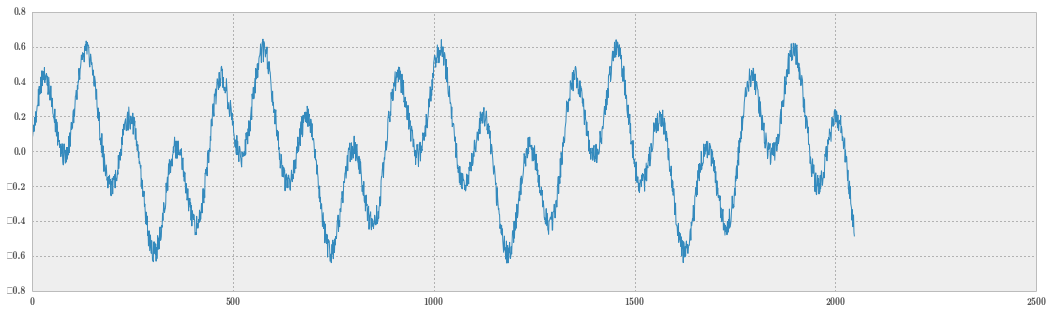

In [27]:
x1 = sine_wave(frequency=100, framerate=44000)
x2 = sine_wave(frequency=400, framerate=44000)
n = white_noise(amplitude=0.2)
x = wave_array(2048,[x1,x2,n])
plt.figure()
plt.plot(x)

In [28]:
%time f = fft(x)

CPU times: user 16.8 ms, sys: 45 µs, total: 16.8 ms
Wall time: 17.2 ms


In [30]:
import scipy.fftpack as fftpack
%time f1 = fftpack.fft(np.array(x))

CPU times: user 894 µs, sys: 0 ns, total: 894 µs
Wall time: 537 µs


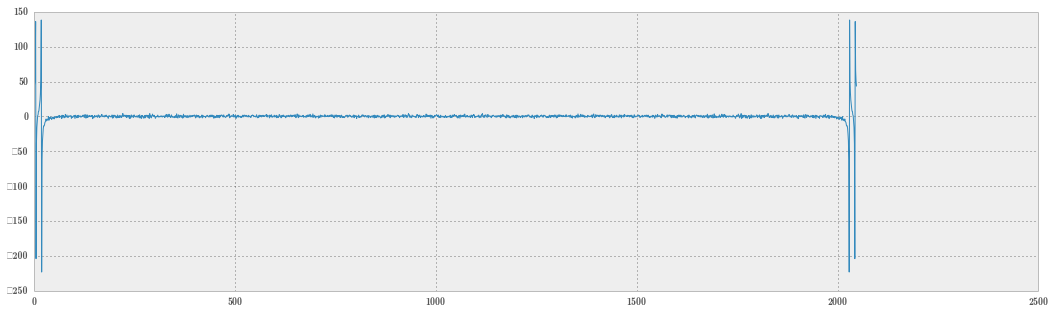

In [31]:
plt.figure()
plt.plot([i.real for i in f ])

# VELOCIDADE / PERFORMANCE

In [39]:
%timeit f1 = np.fft.fft(x)

10000 loops, best of 3: 146 µs per loop


In [40]:
%timeit f1 = np.fft.rfft(x)

10000 loops, best of 3: 133 µs per loop


In [41]:
import scipy.fftpack as fftpack
%timeit f1 = fftpack.fft(x)

The slowest run took 4.55 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 133 µs per loop


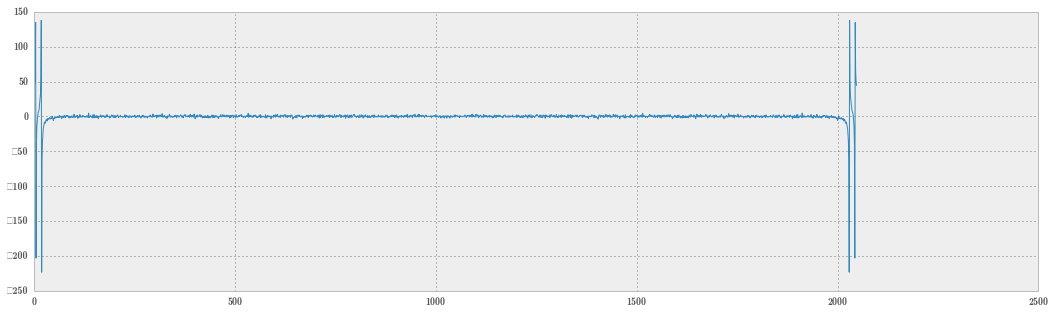

In [24]:
plt.figure()
plt.plot([x.real for x in f1 ])

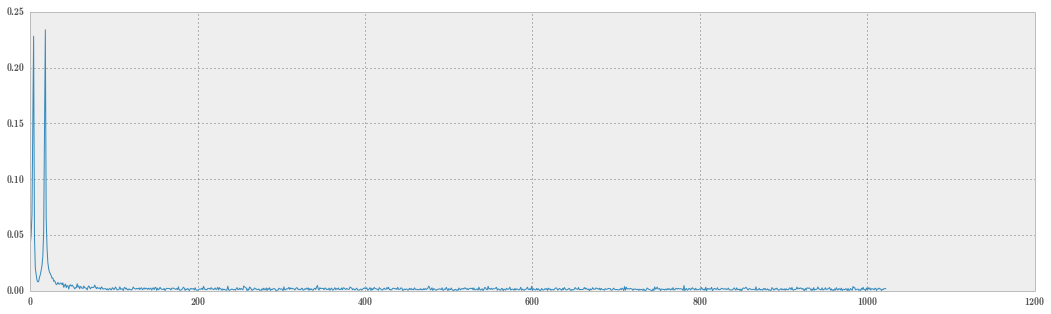

In [9]:
n = len(f)/2
f_a = [abs(x)/n for x in f[1:len(f)/2]]
plt.figure()
plt.plot(f_a)

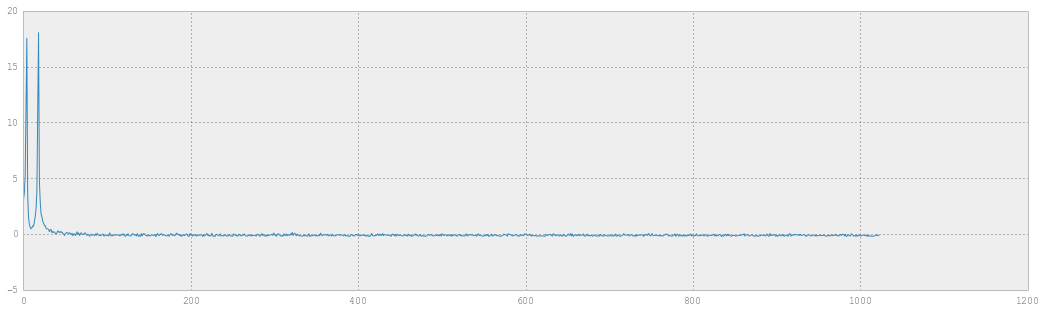

In [213]:
std = np.std(f_a)
mean = np.mean(f_a)
f_z = [(x-mean)/std for x in f_a]
plt.plot(f_z)

In [188]:
f_d = [f_a[i]-f_a[i-1] for i in xrange(len(f_a)-1)]
#plt.plot(f_d)

In [25]:
bin_size = 44000 / 2048
print(bin_size)

for i in xrange(len(f)/2-1):
    a = f[i].real
    b = f[i+1].real
    if a > 0 and b < 0 and (a-b) > 100:        
        print("found at pos {i},  freq:{f}".format(i=i,f=(i+1)*bin_size))


21
found at pos 4,  freq:105
found at pos 18,  freq:399


In [178]:
bin_size * 5

105